In [53]:
from sklearn.datasets import fetch_openml 
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score, precision_recall_curve,roc_curve,roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
#Importando dados

mnist = fetch_openml('mnist_784',version=1,as_frame=False)

c:\Users\klace\anaconda3\envs\ml_book\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
X, y = mnist['data'],mnist['target']
X.shape
y.shape

(70000,)

(-0.5, 27.5, 27.5, -0.5)

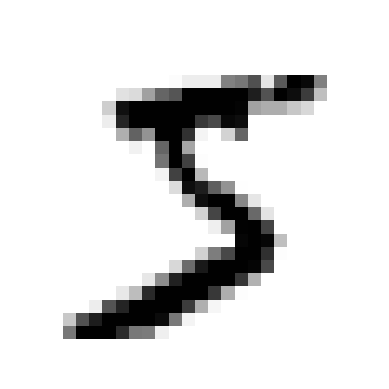

In [5]:
#Visualizando imagens 

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=mpl.cm.binary,interpolation='nearest')
plt.axis('off')


In [6]:
#Transformando target em númerica

y = y.astype(np.uint8)

In [7]:
#Dividindo datasets em treino e teste 

X_train,X_test,y_train,y_teste = X[:60000],X[60000:],y[:60000],y[60000:]

In [8]:
#Treinando um classificador binário 

y_train_5 = y_train == 5
y_test_5 = y_teste == 5
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [9]:
#Prevendo o primeiro número 5

sgd_clf.predict([some_digit])

array([ True])

In [10]:
#Aplicando validação cruzada

cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [11]:
#Comparando a acurácia do modelo com um modelo dum 

from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5clf = Never5Classifier()
cross_val_score(never_5clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [12]:
#Confusion Matrix 

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

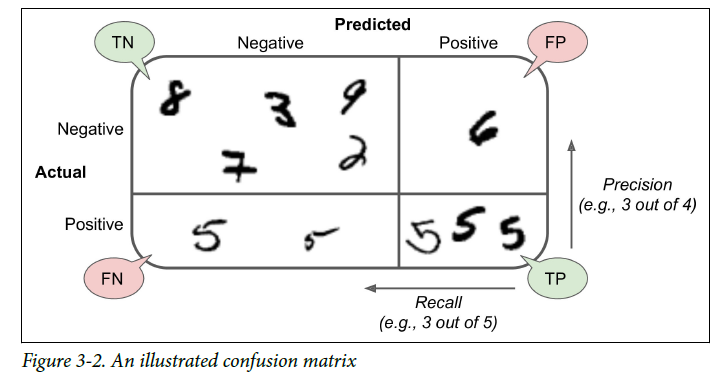

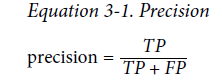

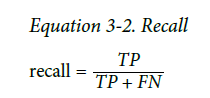

Basicamente, precisão é a taxa de acerto daquilo que o modelo classifica como positivo e recall é a taxa de acerto do modelo em relação a todas as classes positivas.

In [13]:
print("Precisão:" ,precision_score(y_train_5,y_train_pred), ' Recall:', recall_score(y_train_5,y_train_pred))

Precisão: 0.8370879772350012  Recall: 0.6511713705958311


In [14]:
f1_score(y_train_5,y_train_pred)

0.7325171197343846

## Precision e Recall Tradeoff

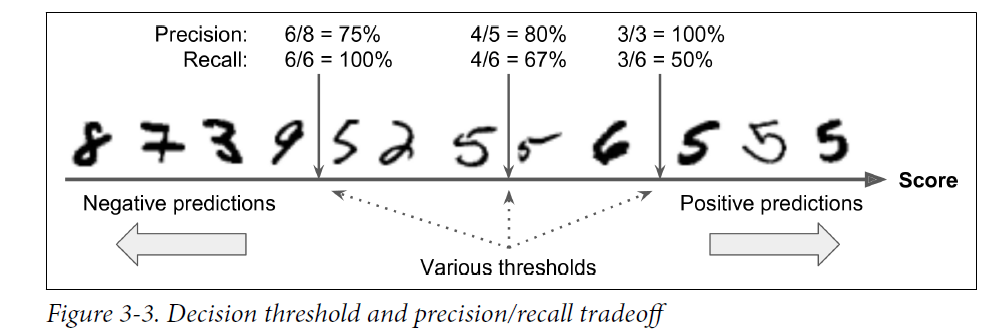

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

#Definindo um threshold 
threshold = 0 
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([ True])

In [19]:
#Como decidir qual threshold usar? 
#Vamos aplicar a validação cruzada para buscar todos os thresholds

y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

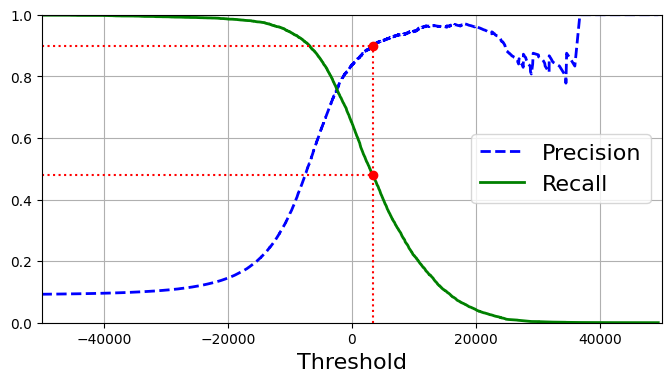

In [21]:
#Plotando precision e recall para qualquer threshold 
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                             
    plt.axis([-50000, 50000, 0, 1])            



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")             
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                               
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                                          
plt.show()



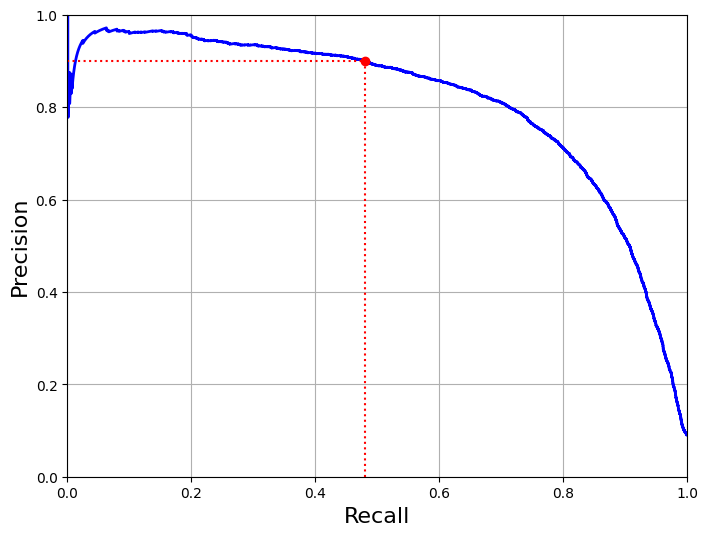

In [22]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [30]:
#Descobrindo o threshold necessário caso queiramos utilizar uma precision de 90%
thresholds_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

In [33]:
#Novas prediçoes 

y_train_pred_90 = y_scores >= threshold_90_precision
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [34]:
confusion_matrix(y_train_5,y_train_pred_90)

array([[54290,   289],
       [ 2819,  2602]], dtype=int64)

In [35]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [36]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

## ROC Curve

In [44]:
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)


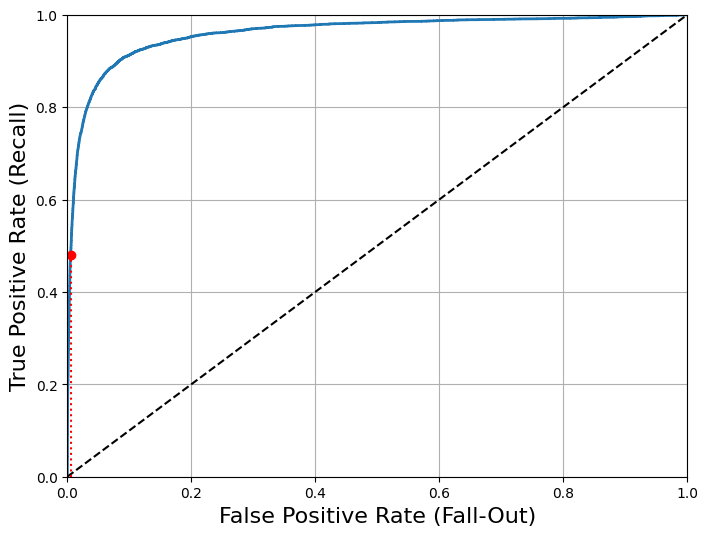

In [48]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                           

plt.figure(figsize=(8, 6))                                   
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")  
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
                                  
plt.show()

In [52]:
#Verificando a área sobre a curva AUC
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

### Treinando um Randon Forest para testar sua curva ROC

In [57]:
forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')

In [62]:
y_scores_forest = y_proba_forest[:,1]
fpr_forest, tpr_forest,thresholds_forest = roc_curve(y_train_5,y_scores_forest)

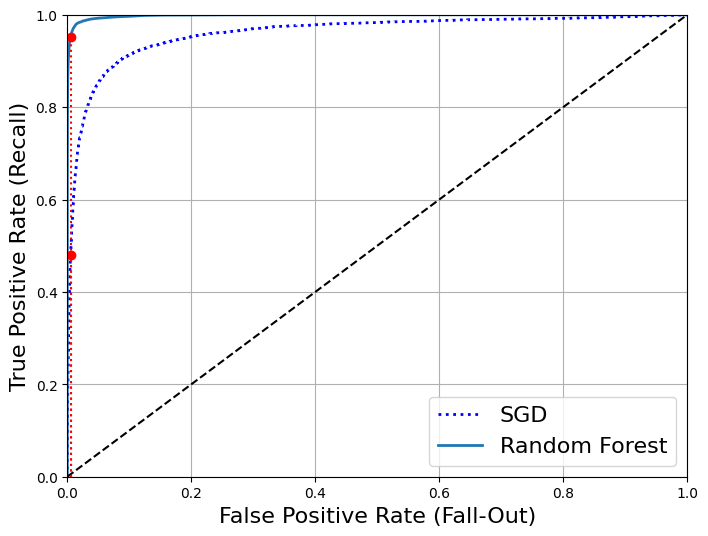

In [63]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [64]:
#Auc do Random Forest 

roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [66]:
y_train_pred_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3)
print('Precision: ',precision_score(y_train_5,y_train_pred_forest)," Recall: ",recall_score(y_train_5,y_train_pred_forest))

Precision:  0.9905083315756169  Recall:  0.8662608374838591
